In [26]:
import numpy as np
def loadGraph(fname, graph_type='u'):
    nodes = []
    with open(fname) as f:
        for line in f:
            pair = line.strip().split()
            nodes.append(int(pair[0]))
            nodes.append(int(pair[1]))

    A_size = max(nodes)+1
    A = np.zeros((A_size,A_size))

    for i in range(0,len(nodes),2):
        A[nodes[i]][nodes[i+1]]=1
        if graph_type == 'u':
            A[nodes[i+1]][nodes[i]]=1
    
    return A

A = loadGraph('metadata/phys.edges', 'd')

def permuteNoiseMat(A, is_perm=True, has_noise=True):
    perm = np.random.permutation(len(A))

    P = np.identity(len(A))
    if is_perm:
        P = P[perm]

    B = P.dot(A).dot(P.T)
    if has_noise:
        noise = np.random.choice([0, 1], size=(len(A),len(A)), p=[99.95/100, 0.05/100])
        B = (B + noise + noise.T)%2
    
    return B

B = permuteNoiseMat(A,is_perm=False, has_noise=True)

with open('metadata/phys-perm.edges', 'w') as f:
    for i in range(len(B)):
        for j in range(len(B)):
            if B[i][j]>0:
                f.write(str(i)+" "+str(j)+"\n")

In [27]:
import snap
import numpy as np
import pandas as pd

def getAttribute(filename):
    Graph = snap.LoadEdgeList(snap.PNGraph, filename, 0, 1)
    
    attributeNames = ['Graph', 'Id', 'Degree', 'InDegree', 'OutDegree', 'NodeBetweennessCentrality', 
                      'FarnessCentrality', 'PageRank', 'HubsScore', 'AuthoritiesScore', 'NodeEccentricity']

    attributes = pd.DataFrame(np.zeros((Graph.GetNodes(), len(attributeNames))), columns=attributeNames)
    
    attributes['Graph'] = [filename] * Graph.GetNodes()
    attributes['Id'] = range(1, Graph.GetNodes()+1)
    
    # Degree
    degree = np.zeros((Graph.GetNodes(),))
    InDegV = snap.TIntPrV()
    snap.GetNodeInDegV(Graph, InDegV)
    for item in InDegV:
        degree[item.GetVal1()-1] = item.GetVal2()
    attributes['Degree'] += degree
    attributes['InDegree'] = degree
    
    degree = np.zeros((Graph.GetNodes(),))
    OutDegV = snap.TIntPrV()
    snap.GetNodeOutDegV(Graph, OutDegV)
    for item in OutDegV:
        degree[item.GetVal1()-1] = item.GetVal2()
    attributes['Degree'] += degree
    attributes['OutDegree'] = degree
    
    attributes['Degree'] /= Graph.GetNodes()
    attributes['InDegree'] /= Graph.GetNodes()
    attributes['OutDegree'] /= Graph.GetNodes()

    # Degree, Closeness, Farness Centrality, Node Eccentricity
    farCentr = np.zeros((Graph.GetNodes(),))
    nodeEcc = np.zeros((Graph.GetNodes(),))
    for NI in Graph.Nodes():
        farCentr[NI.GetId()-1] = snap.GetFarnessCentr(Graph, NI.GetId(), True, True)
        nodeEcc[NI.GetId()-1] = snap.GetNodeEcc(Graph, NI.GetId(), True)
    attributes['FarnessCentrality'] = farCentr
    attributes['NodeEccentricity'] = nodeEcc

    # Betweenness Centrality
    betCentr = np.zeros((Graph.GetNodes(),))
    Nodes = snap.TIntFltH()
    Edges = snap.TIntPrFltH()
    snap.GetBetweennessCentr(Graph, Nodes, Edges, 1.0, True)
    for node in Nodes:
        betCentr[node-1] = Nodes[node]
    attributes['NodeBetweennessCentrality'] = betCentr

    # PageRank
    pgRank = np.zeros((Graph.GetNodes(),))
    PRankH = snap.TIntFltH()
    snap.GetPageRank(Graph, PRankH)
    for item in PRankH:
        pgRank[item-1] = PRankH[item]
    attributes['PageRank'] = pgRank

    # Hubs, Authorities score 
    hubs = np.zeros((Graph.GetNodes(),))
    auth = np.zeros((Graph.GetNodes(),))
    NIdHubH = snap.TIntFltH()
    NIdAuthH = snap.TIntFltH()
    snap.GetHits(Graph, NIdHubH, NIdAuthH)
    for item in NIdHubH:
        hubs[item-1] = NIdHubH[item]
    for item in NIdAuthH:
        auth[item-1] = NIdAuthH[item]
    attributes['HubsScore'] = hubs
    attributes['AuthoritiesScore'] = auth

    return attributes

attributesA = getAttribute("metadata/phys.edges")
with open('metadata/attributes_phys', 'w') as f:
    for index, row in attributesA.iterrows():
        f.write(str(attributesA.ix[index]))
#print attributesA

attributesB = getAttribute("metadata/phys-perm.edges")
with open('metadata/attributes_phys_perm', 'w') as f:
    for index, row in attributesB.iterrows():
        f.write(str(attributesB.ix[index]))
#print attributesB

Degree


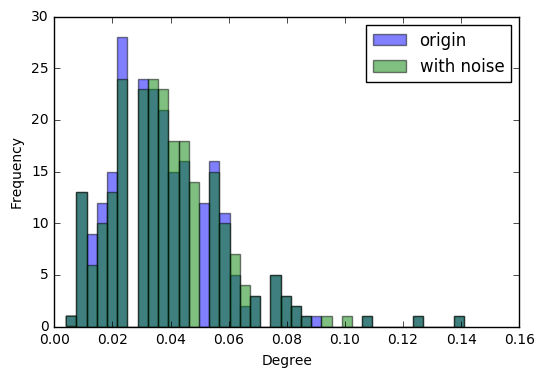

InDegree


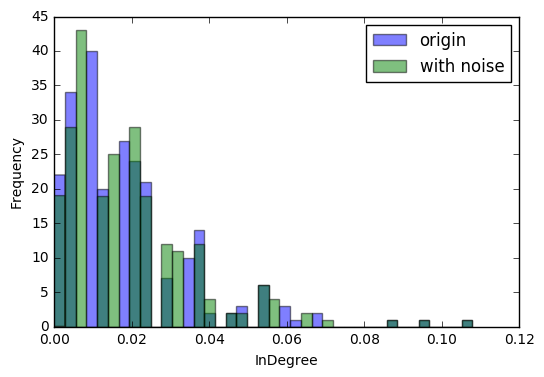

OutDegree


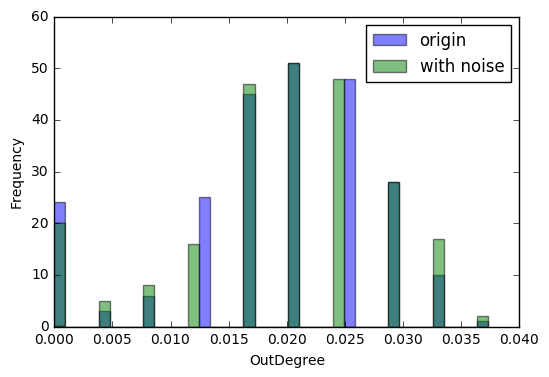

NodeBetweennessCentrality


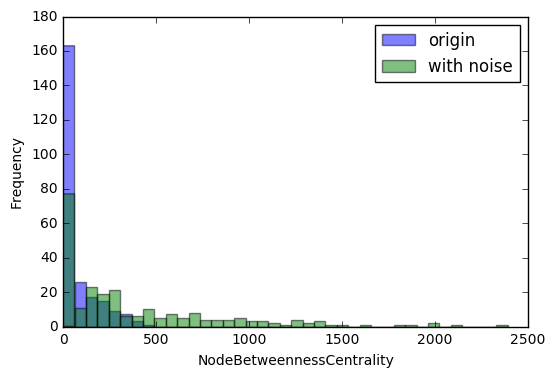

FarnessCentrality


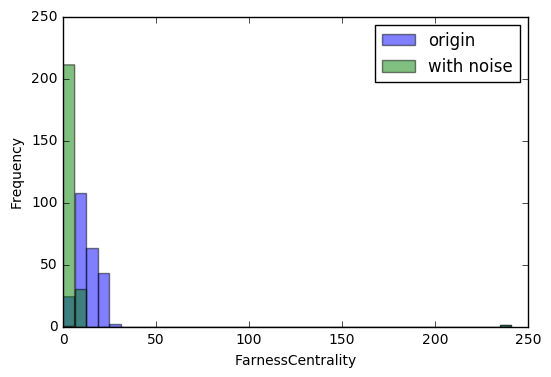

PageRank


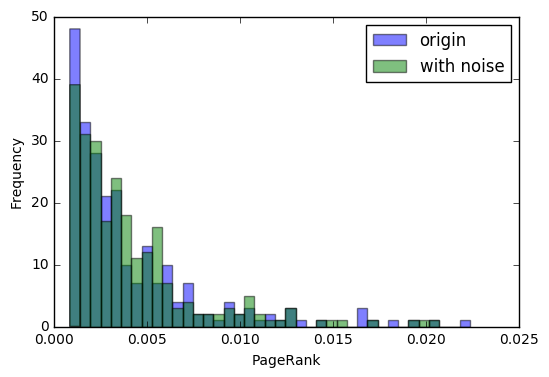

HubsScore


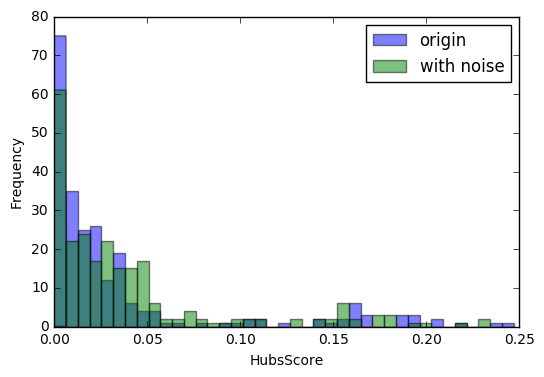

AuthoritiesScore


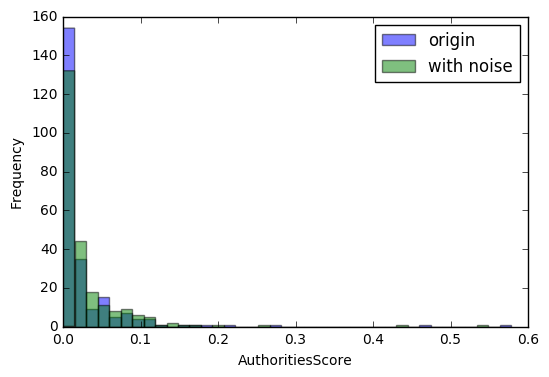

NodeEccentricity


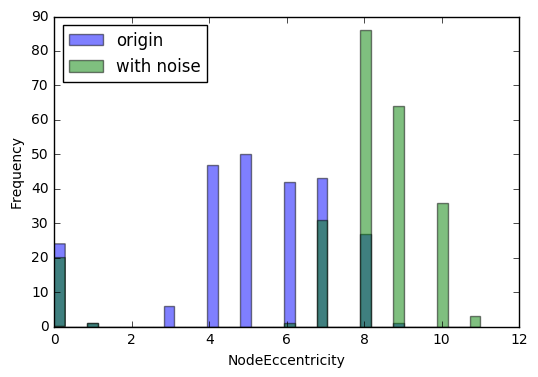

In [28]:
import matplotlib.pyplot as plt

attributes = ['Degree', 'InDegree', 'OutDegree', 'NodeBetweennessCentrality', 
                      'FarnessCentrality', 'PageRank', 'HubsScore', 'AuthoritiesScore', 'NodeEccentricity']
plt.clf()
for attr in attributes:
    print attr
    plt.figure()
    bins = np.linspace(min(min(attributesA[attr]), min(attributesB[attr])), max(max(attributesA[attr]), max(attributesB[attr])), 40)
    plt.hist(attributesA[attr], bins, alpha=0.5, label='origin')
    plt.hist(attributesB[attr], bins, alpha=0.5, label='with noise')
    plt.xlabel(attr)
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

In [31]:
import numpy as np
from collections import defaultdict

def generateBuckets(attributes, cols):
    randMatrix = np.random.random((attributes.shape[1], cols))
    #randMatrix = np.multiply(((randMatrix - 0.5) * 2).T, 1 / np.median(attributes, axis=0)).T
    randMatrix = np.multiply(((randMatrix - 0.5) * 2).T, 1 / np.mean(attributes, axis=0)).T
    #randMatrix = (randMatrix - 0.5) * 2
    signMatrix = attributes.dot(randMatrix)
    signMatrix[signMatrix > 0] = 1
    signMatrix[signMatrix < 0] = 0
    hashMatrix = signMatrix.dot([2**i for i in range(cols)])
    dic = defaultdict(list)
    for i in range(len(hashMatrix)):
        dic[hashMatrix[i]].append(i)
    return dic

def selectAndCombine(A, B, cols):
    return np.vstack((A[cols].as_matrix(), B[cols].as_matrix()))

bandDeg = ['Degree','InDegree','OutDegree']
bucketDeg = generateBuckets(selectAndCombine(attributesA, attributesB, bandDeg), 20)
with open('metadata/buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())

bandEdge = ['NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketEdge = generateBuckets(selectAndCombine(attributesA, attributesB, bandEdge), 20)
with open('metadata/buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())

bandScore = ['PageRank', 'HubsScore', 'AuthoritiesScore']
bucketScore = generateBuckets(selectAndCombine(attributesA, attributesB, bandScore), 20)
with open('metadata/buckets-band-3', 'w') as f:
    for k, v in bucketScore.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketScore.items())

#band4 = ['Degree', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
#bucket4 = generateBuckets(selectAndCombine(attributesA, attributesB, band4), 20)
#with open('metadata/buckets-band-4', 'w') as f:
#    for k, v in bucket4.items():
#        f.write(str(k) + str(v) + '\n')
#print len(bucket4.items())

#band5 = ['InDegree','OutDegree','PageRank', 'HubsScore', 'AuthoritiesScore']
#bucket5 = generateBuckets(selectAndCombine(attributesA, attributesB, band5), 20)
#with open('metadata/buckets-band-5', 'w') as f:
#    for k, v in bucket5.items():
#        f.write(str(k) + str(v) + '\n')
#print len(bucket5.items())

8
26
40


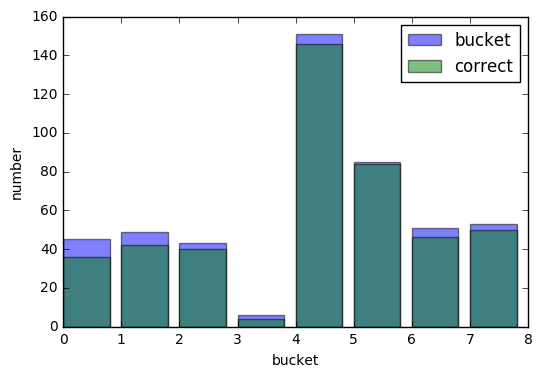

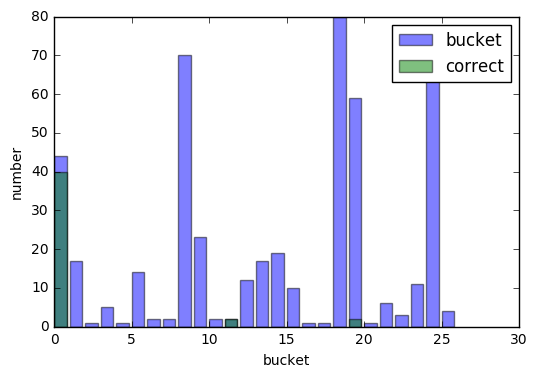

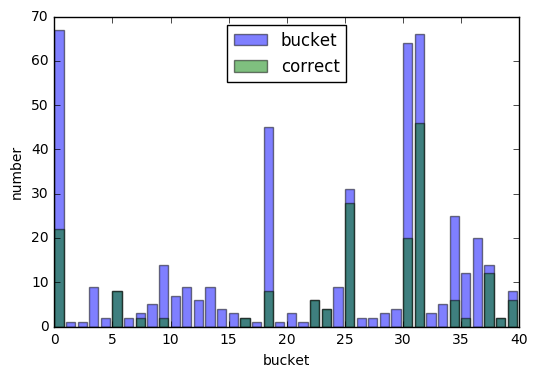

In [32]:
def plotCorrectness(d, n):
    correct = {}
    for v, k in d.items():
        cnt = 0
        for i in k:
            if (i < n):
                if (i + n in k):
                    cnt += 2
            else:
                break
        correct[v] = cnt
    plt.clf
    plt.figure()
    plt.bar(range(len(d)), [len(v) for k,v in d.items()], alpha=0.5, label='bucket', color='blue')
    plt.bar(range(len(correct)), [correct[k] for k,v in d.items()], alpha=0.5, label='correct', color='green')
    plt.xlabel('bucket')
    plt.ylabel('number')
    plt.legend(loc='best')
    plt.show()
    
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketScore, attributesA.shape[0])

In [132]:
from collections import defaultdict

pair_count_dict = defaultdict(int)

for buck, collisions in bucket1.items():
    if len(collisions) <= 1:
        continue
    A_idx = combineAB[collisions,0] == '0.edges'
    B_idx = ~A_idx
    colli_arr = np.array(collisions)
    
    if sum(A_idx) == len(A_idx):
        continue
        
    for aid in colli_arr[A_idx]:
        for bid in colli_arr[B_idx]:
            pair_count_dict[(aid, bid)] += 1
            
for buck, collisions in bucket2.items():
    if len(collisions) <= 1:
        continue
    A_idx = combineAB[collisions,0] == '0.edges'
    B_idx = ~A_idx
    colli_arr = np.array(collisions)
    
    if sum(A_idx) == len(A_idx):
        continue
        
    for aid in colli_arr[A_idx]:
        for bid in colli_arr[B_idx]:
            pair_count_dict[(aid, bid)] += 1

In [133]:
matching_matrix = np.zeros((len(attributesA), len(attributesB)))
scale = np.mean(combineAB[:,1:], axis=0)

def cos_sim(v1, v2, scale=np.ones((len(v1),)) ):
    v1 = np.multiply(v1, 1/scale)
    v2 = np.multiply(v2, 1/scale)
    return v1.dot(v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
            
for pair, count in pair_count_dict.items():
    matching_matrix[pair[0]][pair[1]-len(attributesA)] = cos_sim(combineAB[pair[0]][1:], combineAB[pair[1]][1:],scale=scale)*count
    
matching_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.83442943,  0.        ,  0.        , ...,  0.69113798,
         0.81728296,  0.67787097],
       [ 0.        ,  0.        ,  0.        , ...,  1.32159893,
         1.58474375,  0.65569576],
       [ 0.        ,  0.        ,  0.        , ...,  1.38528002,
         1.61280736,  0.69016815]])

In [134]:
print matching_matrix[0]

sim_vec = []
for j in range(len(attributesA)):
    vec = [cos_sim(combineAB[j,1:], combineAB[len(attributesA)+i,1:], scale) for i in range(len(attributesB)) ]
    sim_vec.append(vec)

show_list = [0, 10, 20, 50]
top_k = 5
for i in show_list:
    print "cos sim top %d for node %d:" %(top_k, attributesA['Id'][i])
    print attributesB['Id'][np.array(sim_vec[i]).argsort()[-top_k:]].values
    print "matching top %d for node %d:"%(top_k, attributesA['Id'][i])
    print attributesB['Id'][matching_matrix[i].argsort()[-top_k:]].values


[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.93524865  0.          0.          0.
  0.81555544  0.89217009  0.          0.97005352  0.91561464  0.
  0.91731571  0.91118255  0.          0.96966739  0.98763741  0.95920576
  0.95501845  0.          0.97775798  0.96656576  0.91131207  0.
  0.87857542  0.8004371   0.8831716   0.          0.92255585  0.          0.
  0.          0.          0.          0.          0.          0.95495101
  0.96845152  0.67211399  0.98070146  0.97162309  0.          0.98243535
  0.          0.          0.95520641  0.96189895  0.99132222  0.73199473
  0.98993713  0.          0.          0.79751488  0.98625557  0.
  0.99387854  0.          0.99738847  0.          0.          0.
  0.98094798  0.9968729   0.99160023  0.          0.88450436  0.90989579
  0.98396698  0.98819926  0.98505446  0.95334136  0.          0.
  0.91842111  0.98856125  0.          0.          0.          0.          0.
  0.          

In [9]:
attributes = pd.DataFrame(np.zeros((3,3)), columns=['a','b','c'])
print (attributes['a'][0])

0.0
